In [35]:
# Solving the committor equation via neural network representation
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import torch

beta = torch.tensor(1) # inverse temperature

In [36]:
# define face potential
def face(x,y):
    xa=-3
    ya=3
    xb=0 
    yb=4.5
    f=(1-x)**2+(y-0.25*x**2)**2+1
    g1=1-np.exp(-0.125*((x-xa)**2+(y-ya)**2))
    g2=1-np.exp(-0.25*(((x-xb)**2+(y-yb)**2)))
    g3=1.2-np.exp(-2*((x+0)**2+(y-2)**2))
    g4=1+np.exp(-2*(x+1.5)**2-(y-3.5)**2-(x+1)*(y-3.5))
    v = f*g1*g2*g3*g4
    return v

In [37]:
# Original potential function
def face_torch(x,y):
    xa=torch.tensor([-3])
    ya=torch.tensor([3])
    xb=torch.tensor([0]) 
    yb=torch.tensor([4.5])

    f=(1-x).pow(2)+(y-0.25*x.pow(2)).pow(2)+1
    g1=1-torch.exp(-0.125*((x-xa).pow(2)+(y-ya).pow(2)))
    g2=1-torch.exp(-0.25*(((x-xb).pow(2)+(y-yb).pow(2))))
    g3=1.2-torch.exp(-2*((x+0).pow(2)+(y-2).pow(2)))
    g4=1+torch.exp(-2*(x+1.5).pow(2)-(y-3.5).pow(2)-(x+1)*(y-3.5))

    v = f*g1*g2*g3*g4
    return v  

In [38]:
# define grid points
nx,ny= (100,100)
nxy = nx*ny
xmin = -4.5
xmax = 4
ymin = -3
ymax = 6
x1 = np.linspace(xmin,xmax,nx)
y1 = np.linspace(ymin,ymax,ny)
x_grid, y_grid = np.meshgrid(x1,y1)
x_vec = np.reshape(x_grid, (nxy,1))
y_vec = np.reshape(y_grid, (nxy,1))

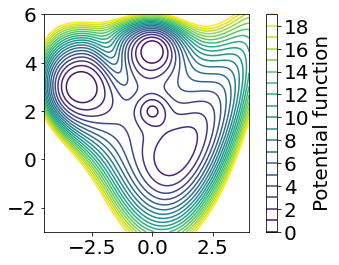

In [39]:
# plot face potential
v_face = np.zeros(nxy)
for j in range(nxy):
    v_face[j] = face(x_vec[j],y_vec[j])
v_face_grid = np.reshape(v_face,(nx,ny))  
ls = plt.contour(x_grid,y_grid,v_face_grid,range(0,20))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

In [5]:
# activation functions
# torch.nn.Sigmoid 1/(1+exp(-x))
# torch.nn.ReLU(inplace: bool = False)  max(0,x)
# m = nn.ReLU()
# input = torch.randn(5)
# output = m(input)
# torch.nn.LeakyReLU(negative_slope: float = 0.01, inplace: bool = False) x if x > 0, ax if x < 0
# torch.nn.Tanh hyperbolic tangent

In [40]:
# import training points
xytrain = np.loadtxt('FaceDeltaNet.csv', delimiter=',', dtype=float)
print(xytrain[0:10,:])

train_data = torch.from_numpy(xytrain).float()
train_data.requires_grad_(True)
print(train_data[0:10,:])

size1,size2 = train_data.shape
print(size1,size2)




[[-3.          3.        ]
 [-3.0594679   2.99538426]
 [-2.91003646  3.1185557 ]
 [-2.93465809  3.01837715]
 [-2.8325937   3.06204319]
 [-2.90966927  2.99949433]
 [-2.94785059  2.89177044]
 [-3.04706365  2.90468201]
 [-3.03600361  2.94689491]
 [-3.00471551  2.87717622]]
tensor([[-3.0000,  3.0000],
        [-3.0595,  2.9954],
        [-2.9100,  3.1186],
        [-2.9347,  3.0184],
        [-2.8326,  3.0620],
        [-2.9097,  2.9995],
        [-2.9479,  2.8918],
        [-3.0471,  2.9047],
        [-3.0360,  2.9469],
        [-3.0047,  2.8772]], grad_fn=<SliceBackward0>)
22341 2


In [41]:
# define neural network: Sigmoid(W1*ReLU(W0*xy+b0)+b1)
class CommittorModelNN(torch.nn.Module):

    def __init__(self,in_size, hidden_size, out_size):
        super(CommittorModelNN, self).__init__()

        self.linear0 = torch.nn.Linear(in_size, hidden_size)
        self.activation0 = torch.nn.Tanh()
        self.linear1 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation1 = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(hidden_size, out_size)
        self.sigmoid = torch.nn.Sigmoid()
                              
    def forward(self,x,a,b,ra,rb):
        q = self.linear0(x)
        q = self.activation0(q)
        q = self.linear1(q)
        q = self.activation1(q)
        q = self.linear2(q)
        q = self.sigmoid(q) 
        sizex, nothing = x.shape
        aux0 = (((x-a).pow(2)).sum(dim=1)).reshape(sizex,1) - (ra+torch.tensor(0.02)).pow(2)
        aux1 =  (((x-b).pow(2)).sum(dim=1)).reshape(sizex,1) - (rb+torch.tensor(0.02)).pow(2)
        chia = 0.5-0.5*torch.tanh(100*aux0)
        chib = 0.5-0.5*torch.tanh(100*aux1)   
#        print("chia = ",chia,"chib = ",chib)
        q = (1-chia)*((1-chib)*q+chib)
#        print("q = ",q.detach())
        return q

# define sets A and B
a = torch.tensor([-3,3])
b = torch.tensor([0,4.5])
ra = torch.tensor(0.5)
rb = torch.tensor(0.5)
# define the dimensions for the neural network
in_size = 2 # the dimension of input data points
hidden_size = 40 # the number of neurons in the hidden layer
out_size = 1 # the output size of the neural network

# test neural network
qmodel = CommittorModelNN(in_size, hidden_size, out_size)
print(qmodel)
xy = train_data[0:2,:]
print(xy)
print("net = ",qmodel(xy,a,b,ra,rb))


CommittorModelNN(
  (linear0): Linear(in_features=2, out_features=40, bias=True)
  (activation0): Tanh()
  (linear1): Linear(in_features=40, out_features=40, bias=True)
  (activation1): Tanh()
  (linear2): Linear(in_features=40, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
tensor([[-3.0000,  3.0000],
        [-3.0595,  2.9954]], grad_fn=<SliceBackward0>)
net =  tensor([[0.],
        [0.]], grad_fn=<MulBackward0>)


In [46]:
# To train the data in batch we need to use 'TensorDataset' and 'DataLoader'
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

rhs = torch.zeros(size1,)

train_dataset = TensorDataset(train_data,rhs)

batch_size = 256 # the batch size is the size of the training data/125

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

loss_fn = torch.nn.L1Loss()

# Here we define the optimizer with learning rate 5e-2:
optimizer1 = optim.Adam(qmodel.parameters(), lr=1e-3)

# reduce the learning rate at the listed epochs by the factor of gamma
scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[1000,2000,3000], gamma=0.1)


In [17]:
# xyg_tensor = torch.from_numpy(np.concatenate((xg,yg),axis = 1)).float()
# xyg_tensor.requires_grad_(True)
# #print(xyg_tensor[0:10,:])
# q = qmodel(xyg_tensor,a,b,ra,rb)

In [47]:
# training qmodel

loss = 1
for epoch in range(100):
    for X,y in train_dataloader:
        optimizer1.zero_grad()

        q = qmodel(X,a,b,ra,rb)
        # print(q)
        
         # potential function with bumps
        V = face_torch(X[:,0],X[:,1])
        
        # #Here we use autograd to calculate the derivative of Q with respect to input X:
        derivQ = torch.autograd.grad(q,X,grad_outputs = torch.ones_like(q),allow_unused=True,\
                                     retain_graph=True,create_graph=True)
        dq = derivQ[0]
        # print("derivQ = ",derivQ)
        # print("derivQ[0] = ",dq)
        # Here to calculate the values of '|\nabla q|^2 e^{\beta*U_bias}'
        # aux = torch.norm(derivQ[0],dim=1)**2
        # aux2 = torch.exp(beta*U_bias)
        # print(aux)
        # print(aux2)
        integrand = (torch.norm(derivQ[0],dim=1)**2)*torch.exp(-beta*V)
        # print((torch.norm(derivQ[0],dim=1)**2).detach().shape)
        # print(torch.exp(beta*U_bias).shape)
        # loss_fn is L1 loss, this is equivalent to taking the absolute value of the 
        # 'output' variable
        loss = torch.sum(integrand) #loss_fn(integrand, y)
        # These two lines are for updating parameters of neural network
        loss.backward()
        optimizer1.step()
        
    scheduler1.step()
    if epoch%10 == 0:
        print(epoch)
        print('epoch = ',epoch,'loss: ',loss)


0
epoch =  0 loss:  tensor(0.0472, grad_fn=<SumBackward0>)
10
epoch =  10 loss:  tensor(0.0700, grad_fn=<SumBackward0>)
20
epoch =  20 loss:  tensor(0.0562, grad_fn=<SumBackward0>)
30
epoch =  30 loss:  tensor(0.0422, grad_fn=<SumBackward0>)
40
epoch =  40 loss:  tensor(0.0635, grad_fn=<SumBackward0>)
50
epoch =  50 loss:  tensor(0.0542, grad_fn=<SumBackward0>)
60
epoch =  60 loss:  tensor(0.0560, grad_fn=<SumBackward0>)
70
epoch =  70 loss:  tensor(0.0702, grad_fn=<SumBackward0>)
80
epoch =  80 loss:  tensor(0.0646, grad_fn=<SumBackward0>)
90
epoch =  90 loss:  tensor(0.0530, grad_fn=<SumBackward0>)


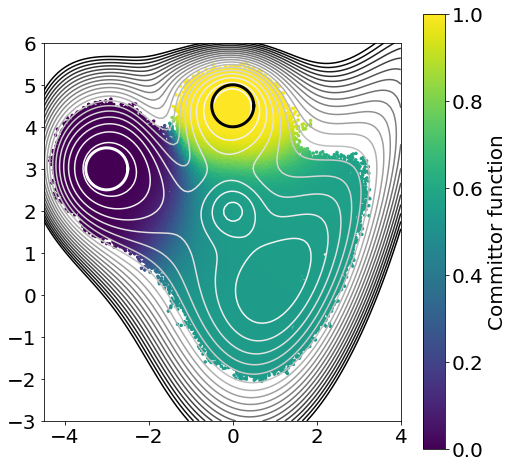

In [57]:
# visualize the computed committor

q_train_data = qmodel(train_data,a,b,ra,rb)

t=np.linspace(0,2*np.pi,100)
Abdry_x = a[0] + ra*np.cos(t)
Abdry_y = a[1] + ra*np.sin(t)
Bbdry_x = b[0] + rb*np.cos(t)
Bbdry_y = b[1] + rb*np.sin(t)

plt.figure(figsize=(8, 8))
ls = plt.contour(x_grid,y_grid,v_face_grid,range(0,20),cmap = "Greys")
plt.scatter(xytrain[:,0],xytrain[:,1],s = 6, c = q_train_data.detach(),cmap = "viridis")
plt.plot(Abdry_x,Abdry_y,linewidth=3,color='white')
plt.plot(Bbdry_x,Bbdry_y,linewidth=3,color='black')
plt.colorbar(label="Committor function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
plt.savefig("FaceCommittorBeta1.pdf")



In [16]:
x = torch.zeros(10,2)
print(x)
print(x-a)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[ 3., -3.],
        [ 3., -3.],
        [ 3., -3.],
        [ 3., -3.],
        [ 3., -3.],
        [ 3., -3.],
        [ 3., -3.],
        [ 3., -3.],
        [ 3., -3.],
        [ 3., -3.]])
